# $fcc$ calculations

This notebook deals with obtaining Sentinel 2 data from before and after the fire. We assume:
* the fire perimeter is available, and 
* we know the date the fire originated.

The code will download a median composite of band reflectance for the 15 days before the start of the fire, and a similar composite of the reflectance 15 days after the fire. These two can then be used to calculate $fcc$

## Downloading data from GEE

We have a simple script to download data from GEE. Here, I assume that we have a geojson file ([`data/Historic_Perimeters_2019.geojson`](data/Historic_Perimeters_2019.geojson)) present that contains the geometry of the fire perimeter as well as some indication of the earliest day of burn. **This is just an example**

The following code snippet will take a while, and it is assumed that you can call the Python EarthEngine bindings in your installation. Once the snippet finishes (it will print a message), you can see the downloaded files in the `s2_data` folder.

For each fire, you get two GeoTIFF files that are clipped to the extent of the fire perimeter (plus some additional 250m buffering). Both files contain the following Sentinel 2 bands in this order:
`sel_bands = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B11", "B12"]`

In [1]:
import warnings
import numpy as np
import json
import datetime
import multiprocessing
from osgeo import gdal
import matplotlib.pyplot as plt
gdal.SetConfigOption('CPL_LOG', '/dev/null')

In [8]:

from gee_grab import getResult

# Let's open the geojson file with some fires
with open("data/h09v05_Aug_GEOJSON_wgs84.geojson", "r") as fp:
    db = json.load(fp)
year = 2018
month = "aug"
tile = "h09v05"
labels = []
geometries = []
burn_dates = []
for sel_idx in range(25):
    label = f"{tile}_{year}_{month}_{sel_idx}"
    geometry = db['features'][sel_idx]['geometry']
    DN = db['features'][sel_idx]['properties']["DN"]
    if DN>=1 and DN <=366:
        
        burn_date =  datetime.datetime.strptime(f"{year}/{DN}", "%Y/%j")
        labels.append(label)
        geometries.append(geometry)
        burn_dates.append(burn_date)
pool = multiprocessing.Pool(5)
filenames = pool.starmap(getResult, zip(labels, geometries, burn_dates))
print("Done downloading!")


No data available. 2018-07-26 00:00:00 <-> 2018-08-26 00:00:00No data available. 2018-07-28 00:00:00 <-> 2018-08-28 00:00:00No data available. 2018-07-30 00:00:00 <-> 2018-08-30 00:00:00No data available. 2018-07-27 00:00:00 <-> 2018-08-27 00:00:00No data available. 2018-07-30 00:00:00 <-> 2018-08-30 00:00:00




No data available. 2018-07-27 00:00:00 <-> 2018-08-27 00:00:00No data available. 2018-07-30 00:00:00 <-> 2018-08-30 00:00:00

No data available. 2018-07-28 00:00:00 <-> 2018-08-28 00:00:00No data available. 2018-07-30 00:00:00 <-> 2018-08-30 00:00:00No data available. 2018-07-26 00:00:00 <-> 2018-08-26 00:00:00


No data available. 2018-07-26 00:00:00 <-> 2018-08-26 00:00:00No data available. 2018-07-25 00:00:00 <-> 2018-08-25 00:00:00No data available. 2018-07-29 00:00:00 <-> 2018-08-29 00:00:00No data available. 2018-07-28 00:00:00 <-> 2018-08-28 00:00:00No data available. 2018-07-30 00:00:00 <-> 2018-08-30 00:00:00




No data available. 2018-07-29 00:00:00 <-> 2018-08-29 0

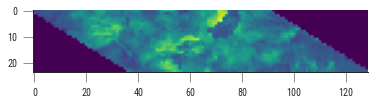

In [7]:
data=gdal.Open("s2_data/h09v05_2021_aug_10_postfire.tif").ReadAsArray()
plt.imshow(data[2])

## Converting GeoJSON in MODIS sinusoidal projection to WGS84 (Lat/Lon)

```
!ogr2ogr -t_srs "EPSG:4326" -s_srs "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext" \
        h09v05_Aug_GEOJSON_wgs84.geojson h09v05_Aug_GEOJSON.geojson 
```

which basically means reproject the seconf file from MODIS sinusoidal to lat/lon and store it in the first filename.

```
!ogr2ogr -t_srs "EPSG:4326" -s_srs "+proj=sinu +R=6371007.181 +nadgrids=@null +wktext" \
        <output_filename>.geojson <input_filename>.geojson 
